# Assess disease progression predictions on diabetes data

This is an adaptation of the [corresponding notebook in the `responsible-ai-toolbox` repository](https://github.com/microsoft/responsible-ai-toolbox/blob/main/notebooks/responsibleaidashboard/responsibleaidashboard-diabetes-regression-model-debugging.ipynb) to work with the Responsible AI components in AzureML.

We will use the Responsible AI components to assess a regression trained on diabetes progression data. Next, we will walk through the API calls necessary to create a widget with model analysis insights, then undertake a visual analysis of the model.

First, we need to specify the version of the RAI components which are available in the workspace. This was specified when the components were uploaded, and will have defaulted to '1':

In [ ]:
version_string = '1'

We also need to give the name of the compute cluster we want to use in AzureML. Later in this notebook, we will create it if it does not already exist:

In [ ]:
compute_name = "cpucluster"

Finally, we need to specify a version for the data and components we will create while running this notebook. This should be unique for the workspace, but the specific value doesn't matter:

In [ ]:
rai_diabetes_regression_example_version_string = '6'

## Accessing the data

First, we need to obtain the dataset and upload it to our AzureML workspace:

In [ ]:
import sklearn.datasets
import pandas as pd

from sklearn.model_selection import train_test_split

In [ ]:
data = sklearn.datasets.load_diabetes()
target_feature = 'y'
continuous_features = data.feature_names
data_df = pd.DataFrame(data.data, columns=data.feature_names)
data_df[target_feature] = data.target

Now, split the data into training and test sets:

In [ ]:
data_train, data_test = train_test_split(data_df, test_size=0.2, random_state=7)

Write to parquet files:

In [ ]:
train_filename = "diabetes_regression_train.parquet"
test_filename = "diabetes_regression_test.parquet"

data_train.to_parquet(train_filename, index=False)
data_test.to_parquet(test_filename, index=False)

We are going to create two Datasets in AzureML, one for the train and one for the test datasets. The first step is to create an `MLClient` to perform the upload. The method we use assumes that there is a `config.json` file (downloadable from the Azure or AzureML portals) present in the same directory as this notebook file:

In [ ]:
from azure.ml import MLClient
from azure.identity import DefaultAzureCredential
ml_client = MLClient.from_config(credential=DefaultAzureCredential(exclude_shared_token_cache_credential=True),
                     logging_enable=True)

We can then define and upload the datasets:

In [ ]:
from azure.ml.entities import Data
from azure.ml.constants import AssetTypes

input_train_data = "adult_train_pq"
input_test_data = "adult_test_pq"

train_data = Data(
    path=train_filename,
    type=AssetTypes.URI_FILE,
    description="RAI diabetes regression example training data",
    name=input_train_data,
    version=rai_diabetes_regression_example_version_string,
)
ml_client.data.create_or_update(train_data)

test_data = Data(
    path=train_filename,
    type=AssetTypes.URI_FILE,
    description="RAI diabetes regression example test data",
    name=input_test_data,
    version=rai_diabetes_regression_example_version_string,
)
ml_client.data.create_or_update(test_data)

## A model training pipeline

To simplify the model creation process, we're going to use a pipeline. This will have two stages:

1. The actual training component
1. A model registration component

We have to register the model in AzureML in order for our RAI insights components to use it.

### The Training Component

The training component is for this particular model. In this case, we are going to train a `RandomForestRegressor` on the input data and save it using MLFlow. We need command line arguments to specify the location of the input data, the location where MLFlow should write the output model, and the name of the target column in the dataset.

We start by creating a directory to hold the component source:

In [ ]:
import os

os.makedirs('component_src', exist_ok=True)

Next, put our training script into the directory:

In [ ]:
%%writefile component_src/diabetes_regression_training_script.py

import argparse
import os
import shutil
import tempfile


from azureml.core import Run

import mlflow
import mlflow.sklearn

import pandas as pd
from sklearn.ensemble import RandomForestRegressor

def parse_args():
    # setup arg parser
    parser = argparse.ArgumentParser()

    # add arguments
    parser.add_argument("--training_data", type=str, help="Path to training data")
    parser.add_argument("--target_column_name", type=str, help="Name of target column")
    parser.add_argument("--model_output", type=str, help="Path of output model")

    # parse args
    args = parser.parse_args()

    # return args
    return args


def main(args):
    current_experiment = Run.get_context().experiment
    tracking_uri = current_experiment.workspace.get_mlflow_tracking_uri()
    print("tracking_uri: {0}".format(tracking_uri))
    mlflow.set_tracking_uri(tracking_uri)
    mlflow.set_experiment(current_experiment.name)

    # Read in data
    print("Reading data")
    all_data = pd.read_parquet(args.training_data)

    print("Extracting X_train, y_train")
    print("all_data cols: {0}".format(all_data.columns))
    y_train = all_data[args.target_column_name]
    X_train = all_data.drop(labels=args.target_column_name, axis="columns")
    print("X_train cols: {0}".format(X_train.columns))

    print("Training model")
    # The estimator can be changed to suit
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Saving model with mlflow - leave this section unchanged
    with tempfile.TemporaryDirectory() as td:
        print("Saving model with MLFlow to temporary directory")
        tmp_output_dir = os.path.join(td, "my_model_dir")
        mlflow.sklearn.save_model(sk_model=model, path=tmp_output_dir)

        print("Copying MLFlow model to output path")
        for file_name in os.listdir(tmp_output_dir):
            print("  Copying: ", file_name)
            # As of Python 3.8, copytree will acquire dirs_exist_ok as
            # an option, removing the need for listdir
            shutil.copy2(src=os.path.join(tmp_output_dir, file_name), dst=os.path.join(args.model_output, file_name))


# run script
if __name__ == "__main__":
    # add space in logs
    print("*" * 60)
    print("\n\n")

    # parse args
    args = parse_args()

    # run main function
    main(args)

    # add space in logs
    print("*" * 60)
    print("\n\n")

Now that the training script is saved on our local drive, we create a YAML file to describe it as a component to AzureML. This involves defining the inputs and outputs, specifing the AzureML environment which can run the script, and telling AzureML how to invoke the training script:

In [ ]:
from azure.ml.entities import load_component

yaml_contents = f"""
$schema: http://azureml/sdk-2-0/CommandComponent.json
name: rai_diabetes_regression_training_component
display_name: Diabetes regression training component for RAI example
version: {rai_diabetes_regression_example_version_string}
type: command
inputs:
  training_data:
    type: path
  target_column_name:
    type: string
outputs:
  model_output:
    type: path
code: ./component_src/
environment: azureml:AML-RAI-Environment:{version_string}
""" + r"""
command: >-
  python diabetes_regression_training_script.py
  --training_data ${{{{inputs.training_data}}}}
  --target_column_name ${{{{inputs.target_column_name}}}}
  --model_output ${{{{outputs.model_output}}}}
"""

yaml_filename = "RAIHousingTrainingComponent.yaml"

with open(yaml_filename, 'w') as f:
    f.write(yaml_contents.format(yaml_contents))
    
train_component_definition = load_component(
    yaml_file=yaml_filename
)

ml_client.components.create_or_update(train_component_definition)

### Running a training pipeline

The component to register the model is part of the suite of RAI components, so we do not have to define it here. As such, we are now ready to run the training pipeline itself.

We start by ensuring that the compute cluster named above exists:

In [ ]:
from azure.ml.entities import AmlCompute

all_compute_names = [x.name for x in ml_client.compute.list()]

if compute_name in all_compute_names:
    print(f"Found existing compute: {compute_name}")
else:
    my_compute = AmlCompute(
        name=compute_name,
        size="Standard_DS2_v2",
        min_instances=0,
        max_instances=4,
        idle_time_before_scale_down=3600
    )
    ml_client.compute.begin_create_or_update(my_compute)
    print("Initiated compute creation")

We continue by defining the name under which we want to register the model:

In [ ]:
import time

model_name_suffix = int(time.time())
model_name = 'rai_diabetes_regression_model'

Next, we define the pipeline using objects from the AzureML SDKv2. As mentioned above, there are two component jobs: one to train the model, and one to register it:

In [ ]:
from azure.ml import dsl, Input

register_component = load_component(
    client=ml_client, name="register_model", version=version_string
)
train_model_component = load_component(
    client=ml_client, name="rai_diabetes_regression_training_component", version=rai_diabetes_regression_example_version_string
)
diabetes_train_pq = Input(
    type="uri_file", path=f"{input_train_data}:{rai_diabetes_regression_example_version_string}", mode="download"
)
diabetes_test_pq = Input(
    type="uri_file", path=f"{input_test_data}:{rai_diabetes_regression_example_version_string}", mode="download"
)

@dsl.pipeline(
    compute=compute_name,
    description="Register Model for RAI Diabetes Regression example",
    experiment_name=f"RAI_Diabetes_Regression_Example_Model_Training_{model_name_suffix}",
)
def my_training_pipeline(target_column_name, training_data):
    trained_model = train_component_definition(
        target_column_name=target_column_name,
        training_data=training_data
    )
    trained_model.set_limits(timeout=120)

    _ = register_component(
        model_input_path=trained_model.outputs.model_output,
        model_base_name=model_name,
        model_name_suffix=model_name_suffix,
    )

    return {}

model_registration_pipeline_job = my_training_pipeline(target_feature, diabetes_train_pq)

With the pipeline definition created, we can submit it to AzureML. We define a helper function to do the submission, which waits for the submitted job to complete:

In [ ]:
from azure.ml.entities import PipelineJob

def submit_and_wait(ml_client, pipeline_job) -> PipelineJob:
    created_job = ml_client.jobs.create_or_update(pipeline_job)
    assert created_job is not None

    while created_job.status not in ['Completed', 'Failed', 'Canceled', 'NotResponding']:
        time.sleep(30)
        created_job = ml_client.jobs.get(created_job.name)
        print("Latest status : {0}".format(created_job.status))
    assert created_job.status == 'Completed'
    return created_job

# This is the actual submission
training_job = submit_and_wait(ml_client, model_registration_pipeline_job)

##  Creating the RAI Insights

We have a registered model, and can now run a pipeline to create the RAI insights. First off, compute the name of the model we registered:

In [ ]:
expected_model_id = f'{model_name}_{model_name_suffix}:1'

Now, we create the RAI pipeline itself. There are four 'component stages' in this pipeline:

1. Fetch the model
1. Construct an empty `RAIInsights` object
1. Run the RAI tool components
1. Gather the tool outputs into a single `RAIInsights` object

We start by loading the RAI component definitions for use in our pipeline:

In [ ]:
fetch_model_component = load_component(
    client=ml_client, name='fetch_registered_model', version=version_string
)

rai_constructor_component = load_component(
    client=ml_client, name="rai_insights_constructor", version=version_string
)

rai_counterfactual_component = load_component(
    client=ml_client, name="rai_insights_counterfactual", version=version_string
)

rai_explanation_component = load_component(
    client=ml_client, name="rai_insights_explanation", version=version_string
)

rai_erroranalysis_component = load_component(
    client=ml_client, name="rai_insights_erroranalysis", version=version_string
)

rai_gather_component = load_component(
    client=ml_client, name="rai_insights_gather", version=version_string
)

Now the pipeline itself. This fetches the registered model, creates an empty `RAIInsights` object, adds the analyses, and then gathers everything into the final `RAIInsights` output:

In [ ]:
import json

@dsl.pipeline(
        compute=compute_name,
        description="Example RAI computation on diabetes regression data",
        experiment_name=f"RAI_Diabetes_Regression_Example_RAIInsights_Computation_{model_name_suffix}",
    )
def rai_classification_pipeline(
        target_column_name,
        train_data,
        test_data,
    ):
        # Fetch the model
        fetch_job = fetch_model_component(
            model_id=expected_model_id
        )
        
        # Initiate the RAIInsights
        create_rai_job = rai_constructor_component(
            title="RAI Dashboard Example",
            task_type="regression",
            model_info_path=fetch_job.outputs.model_info_output_path,
            train_dataset=train_data,
            test_dataset=test_data,
            target_column_name=target_column_name,
        )
        
        # Add an explanation
        explain_job = rai_explanation_component(
            comment="Explanation for the diabetes regression dataset",
            rai_insights_dashboard=create_rai_job.outputs.rai_insights_dashboard,
        )
        
        # Add error analysis
        erroranalysis_job = rai_erroranalysis_component(
            rai_insights_dashboard=create_rai_job.outputs.rai_insights_dashboard,
        )
        
        # Add counterfactual analysis
        counterfactual_job = rai_counterfactual_component(
            rai_insights_dashboard=create_rai_job.outputs.rai_insights_dashboard,
            total_cfs=20,
            desired_range='[50, 120]',
        )
        counterfactual_job.set_limits(timeout=600)

        # Combine everything
        rai_gather_job = rai_gather_component(
            constructor=create_rai_job.outputs.rai_insights_dashboard,
            insight_1=explain_job.outputs.explanation,
            insight_3=counterfactual_job.outputs.counterfactual,
            insight_4=erroranalysis_job.outputs.error_analysis,
        )

        rai_gather_job.outputs.dashboard.mode = "upload"
        rai_gather_job.outputs.ux_json.mode = "upload"

        return {
            "dashboard": rai_gather_job.outputs.dashboard,
            "ux_json": rai_gather_job.outputs.ux_json,
        }

Next, we define the pipeline object itself, and ensure that the outputs will be available for download:

In [ ]:
import uuid
from azure.ml import Output

# Pipeline to construct the RAI Insights
insights_pipeline_job = rai_classification_pipeline(
    target_column_name=target_feature,
    train_data=diabetes_train_pq,
    test_data=diabetes_test_pq,
)

# Workaround to enable the download
rand_path = str(uuid.uuid4())
insights_pipeline_job.outputs.dashboard = Output(
    path=f"azureml://datastores/workspaceblobstore/paths/{rand_path}/dashboard/",
    mode="upload",
    type="uri_folder",
)
insights_pipeline_job.outputs.ux_json = Output(
    path=f"azureml://datastores/workspaceblobstore/paths/{rand_path}/ux_json/",
    mode="upload",
    type="uri_folder",
)

And submit the pipeline to AzureML for execution:

In [ ]:
insights_job = submit_and_wait(ml_client, insights_pipeline_job)

The dashboard should appear in the AzureML portal in the registered model view. The following cell computes the expected URI:

In [ ]:
sub_id = ml_client._operation_scope.subscription_id
rg_name = ml_client._operation_scope.resource_group_name
ws_name = ml_client.workspace_name

expected_uri = f"https://ml.azure.com/model/{expected_model_id}/model_analysis?wsid=/subscriptions/{sub_id}/resourcegroups/{rg_name}/workspaces/{ws_name}"

print(f"Please visit {expected_uri} to see your analysis")

Following the link should bring you to a page which looks similar to:
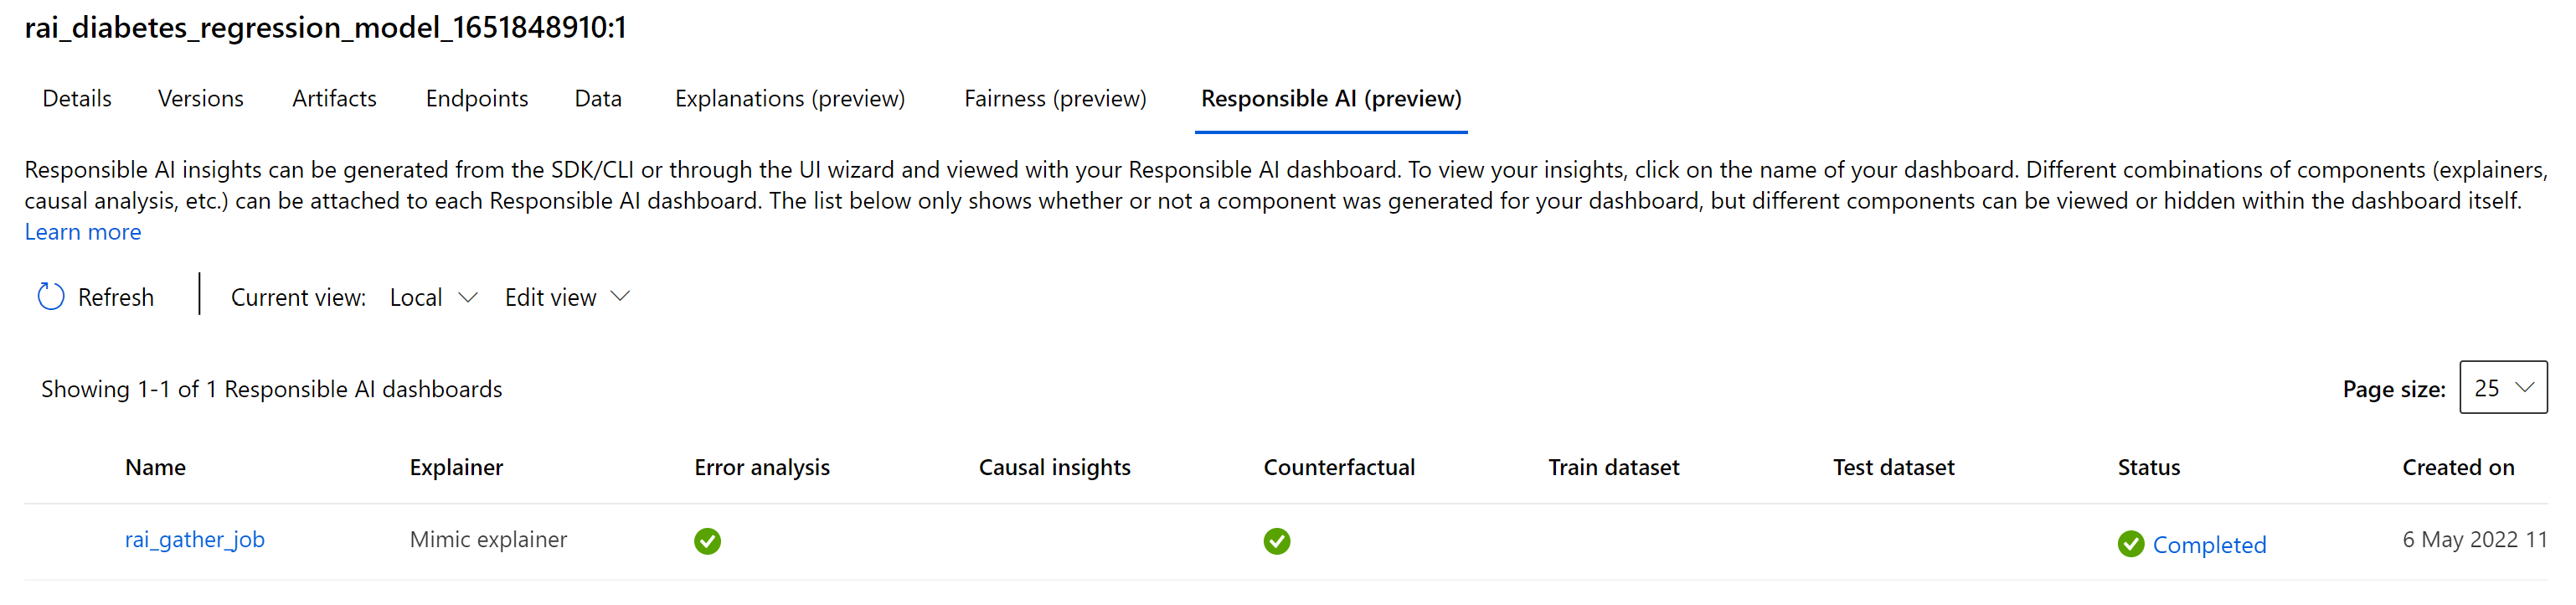

This page lists all of the RAI dashboards computed for this model. To view one, click on the appropriate entry in the 'Name' column.

### Constructing the Pipeline in YAML

Before we examine the dashboard itself, note that it is possible to construct and submit the same pipeline as above using a YAML file and the Azure CLI.

We can create the required YAML file as follows:

In [ ]:
yaml_contents = f"""
$schema: https://azuremlschemas.azureedge.net/latest/pipelineJob.schema.json
experiment_name: RAI_Diabetes_Regression_Example_YAML_{rai_diabetes_regression_example_version_string}
type: pipeline

inputs:
  target_column_name: {target_feature}
  my_training_data:
    type: uri_file
    path: azureml:{input_train_data}:{rai_diabetes_regression_example_version_string}
    mode: download
  my_test_data:
    type: uri_file
    path: azureml:{input_train_data}:{rai_diabetes_regression_example_version_string}
    mode: download

settings:
  default_datastore: azureml:workspaceblobstore
  default_compute: azureml:cpucluster
  continue_on_step_failure: false

jobs:
  fetch_model_job:
    type: command
    component: azureml:fetch_registered_model:{version_string}
    inputs:
      model_id: {expected_model_id}

  create_rai_job:
    type: command
    component: azureml:rai_insights_constructor:{version_string}
    inputs:
      title: RAI Diabetes Regression Analysis from YAML
      task_type: regression
      model_info_path: ${{{{parent.jobs.fetch_model_job.outputs.model_info_output_path}}}}
      train_dataset: ${{{{parent.inputs.my_training_data}}}}
      test_dataset: ${{{{parent.inputs.my_test_data}}}}
      target_column_name: ${{{{parent.inputs.target_column_name}}}}
      
  explain_01:
    type: command
    component: azureml:rai_insights_explanation:{version_string}
    inputs:
      comment: Explanation from YAML for RAI Diabetes Regression example
      rai_insights_dashboard: ${{{{parent.jobs.create_rai_job.outputs.rai_insights_dashboard}}}}

  counterfactual_01:
    type: command
    component: azureml:rai_insights_counterfactual:{version_string}
    inputs:
      rai_insights_dashboard: ${{{{parent.jobs.create_rai_job.outputs.rai_insights_dashboard}}}}
      total_CFs: 20
      desired_range: '[50, 120]'

  error_analysis_01:
    type: command
    component: azureml:rai_insights_erroranalysis:{version_string}
    inputs:
      rai_insights_dashboard: ${{{{parent.jobs.create_rai_job.outputs.rai_insights_dashboard}}}}

  gather_01:
    type: command
    component: azureml:rai_insights_gather:{version_string}
    inputs:
      constructor: ${{{{parent.jobs.create_rai_job.outputs.rai_insights_dashboard}}}}
      insight_2: ${{{{parent.jobs.counterfactual_01.outputs.counterfactual}}}}
      insight_3: ${{{{parent.jobs.error_analysis_01.outputs.error_analysis}}}}
      insight_4: ${{{{parent.jobs.explain_01.outputs.explanation}}}}
"""

yaml_pipeline_filename = "rai_diabetes_regression_example.yaml"

with open(yaml_pipeline_filename, 'w') as f:
    f.write(yaml_contents)

The created file can then be submitted using the Azure CLI:

In [ ]:
cmd_line = ['az', 'ml', 'job', 'create',
            '--resource-group', rg_name,
            '--workspace', ws_name,
            '--file', yaml_pipeline_filename]

import subprocess

try:
    cmd = subprocess.run(cmd_line, check=True, shell=True, capture_output=True)
except subprocess.CalledProcessError as cpe:
    print(f"Error invoking: {cpe.args}")
    print(cpe.stdout)
    print(cpe.stderr)
    raise
else:
    print("Azure CLI submission completed")